## Langchain - 전처리


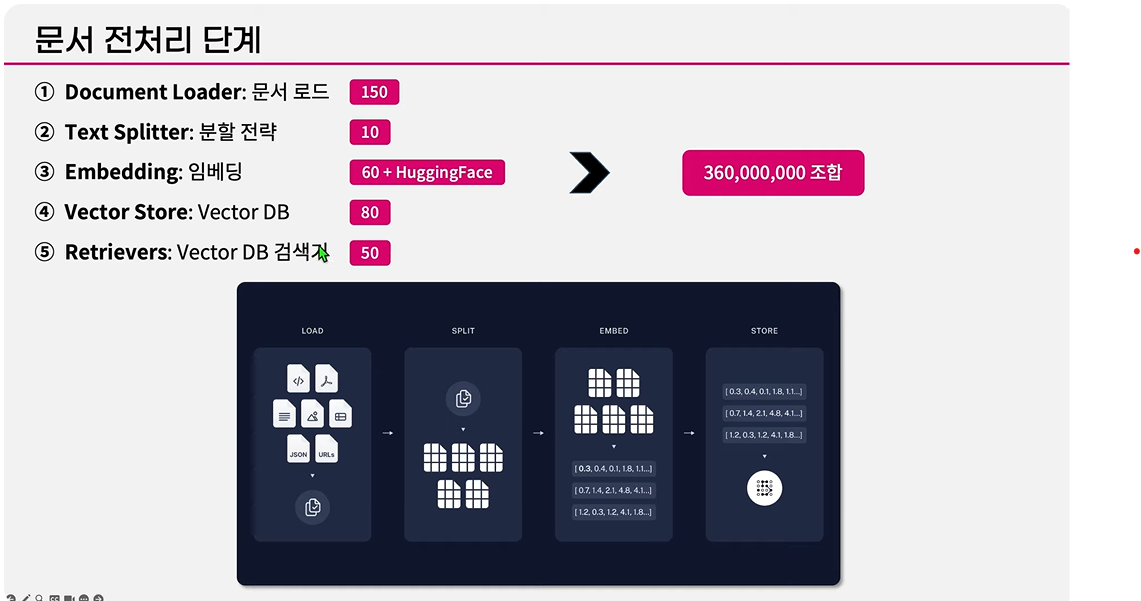
참조 :https://www.youtube.com/watch?v=NfQrRQmDrcc


In [ ]:
# 환경 변수 
from dotenv import load_dotenv
load_dotenv()

In [33]:
pip install -U langchain_community
pip install -U langchain-ollama
pip install -U langgraph


SyntaxError: invalid syntax (1535691273.py, line 1)

In [12]:
from ollama import list
from ollama import ListResponse

response: ListResponse = list()

for model in response.models:
  print('Name:', model.model)

Name: llama3.2-vision:latest
Name: EEVE-Korean-Q5_K_M:latest


In [19]:
model_name = "EEVE-Korean-Q5_K_M"

In [17]:
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model=model_name)

In [14]:
from langchain_core.prompts import ChatPromptTemplate


template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

chain = prompt | llm

chain.invoke({"question": "What is LangChain?"})

'단계 1: 주제 파악하기 - 이 경우, 주제는 "Langchain"입니다.\n\n단계 2: 맥락 결정하기 - 질문은 LangChain에 대한 정의나 설명을 요구하고 있습니다.\n\n단계 3: 연구 및 정보 수집하기 - LangChain에 관한 정보를 찾아 사용자의 질문에 답하겠습니다.\n\nLangChain은 다양한 언어 처리 작업을 수행하기 위해 설계된 오픈소스 플랫폼이자 라이브러리입니다. 자연어 이해(NLU), 자연어 생성(NLG), 대규모 데이터셋을 위한 병렬 처리에 특화된 강력한 엔드투엔드 솔루션을 제공하도록 만들어졌습니다. LangChain의 목표는 개발자들이 언어 관련 애플리케이션을 구축할 때 쉽게 통합하고 확장할 수 있는 모듈식 아키텍처와 사전 훈련된 모델들을 제공하는 것입니다.\n\nLangChain은 파이썬으로 작성되어 있으며 TensorFlow, PyTorch, Hugging Face Transformers와 같은 인기있는 라이브러리와 프레임워크와의 원활한 통합을 가능하게 하는 다양한 언어 처리를 위한 플러그인 및 확장 기능을 제공합니다. 개발자들은 이러한 도구를 사용하여 챗봇, 요약기, 감정 분석 모델과 같은 응용 프로그램을 구축할 수 있습니다.\n\n요약하자면, LangChain은 자연어 이해(NLU), 자연어 생성(NLG) 작업을 포함한 다양한 언어 처리 작업을 수행하기 위한 오픈소스 플랫폼이자 라이브러리입니다. 개발자들이 그들의 언어 관련 애플리케이션에서 사용할 수 있는 강력한 엔드투엔드 솔루션을 제공합니다.'

In [15]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("answer in korean"),
    HumanMessage("hi!"),
]
chain.invoke(messages)


"질문: [SystemMessage(content='answer in korreaen', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi!', additional_kwargs={}, response_metadata={})]\n\n답변: 단계별로 생각해봅시다."

In [104]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[str, add_messages]



In [116]:
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage

chat = ChatOllama(model=model_name)

def chatbot(state: State):
    print('--> chatbot : start')
    # messages = [
    #     SystemMessage(content=msg[1]) if msg[0] == "system" else
    #     HumanMessage(content=msg[1]) if msg[0] == "user" else
    #     msg for msg in state["messages"]
    # ]
    # Get the response as a string
    response = chat.invoke(messages)

    print(f"--> chatbot : after llm.invoke : {response}")
    # Create an AIMessage instead of returning raw response
    from langchain_core.messages import AIMessage
    return {"messages": [AIMessage(content=str(response))]}

In [120]:

del graph_builder
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()



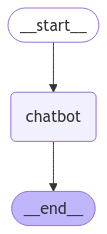

In [84]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [107]:
# stream_graph_updates 함수는 사용자의 입력을 받아 그래프를 통해 응답을 스트리밍하는 함수입니다
def stream_graph_updates(user_input: str):
    # graph.stream()을 사용하여 사용자 입력을 그래프에 전달하고 응답을 스트리밍합니다
    # {"messages": [("user", user_input)]} 형태로 입력을 포맷팅합니다
    for event in graph.stream({"messages": [("user", user_input)]}):
        # 각 이벤트에서 값을 추출하여 출력합니다
        for value in event.values():
            # Assistant: 프리픽스와 함께 메시지의 마지막 컨텐츠를 출력합니다
            print("Assistant:", value["messages"][-1].content)


# 메인 대화 루프입니다
while True:
    try:
        # 사용자로부터 입력을 받습니다
        user_input = input("User: ")
        
        # 종료 명령어를 확인합니다 (quit, exit, q)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # 사용자 입력을 처리하여 응답을 생성합니다
        stream_graph_updates(user_input)
    except:
        # input() 함수를 사용할 수 없는 경우의 대체 로직입니다
        # 기본 질문으로 "What do you know about LangGraph?"를 사용합니다
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

--> chatbot : start
User: What do you know about LangGraph?
--> chatbot : start


TypeError: 'HumanMessage' object is not subscriptable

In [121]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10)

inputs = State(messages="현재 시간은?")
outputs = graph.invoke(inputs, config)

print(outputs)

--> chatbot : start


TypeError: 'NoneType' object is not iterable